# Task 01 - Iris Dataset
The Iris flower data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper. The data set consists of 50 samples from each of three species of Iris (Iris Setosa, Iris virginica, and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
torch.__version__

'2.8.0+cu126'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class IrisDataSet(Dataset):

    def __init__(self, csv_file, is_test):
        super().__init__()
        self.df = pd.read_csv(csv_file)
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        item = self.df.iloc[index]

        # Return data        
        if self.is_test:
            data = item.iloc[1:].values
            return torch.tensor(data, dtype=torch.float32)
        # Return data, label
        else:
            data = item.iloc[1:-1].values
            label = item.iloc[-1]
            return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [5]:
train_dataset = IrisDataSet('./../datasets/iris-train.csv', False)
test_dataset = IrisDataSet('./../datasets/iris-test.csv', True)
train_dataset.df.head(5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,59,6.6,2.9,4.6,1.3,Iris-versicolor
1,98,6.2,2.9,4.3,1.3,Iris-versicolor
2,130,7.2,3.0,5.8,1.6,Iris-virginica
3,115,5.8,2.8,5.1,2.4,Iris-virginica
4,147,6.3,2.5,5.0,1.9,Iris-virginica


In [6]:
train_dataset.df.isna().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [7]:
test_dataset.df.isna().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
dtype: int64

In [8]:
feats = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
target = 'Species'

In [9]:
scaler = StandardScaler()
train_dataset.df[feats] = scaler.fit_transform(train_dataset.df[feats])
test_dataset.df[feats] = scaler.transform(test_dataset.df[feats])
train_dataset.df[feats].head(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,0.871108,-0.391723,0.460434,0.106720
1,0.393788,-0.391723,0.291639,0.106720
2,1.587087,-0.159016,1.135611,0.494792
3,-0.083531,-0.624430,0.741758,1.529650
4,0.513118,-1.322550,0.685493,0.882864


In [10]:
encoder = LabelEncoder()
train_dataset.df[target] = encoder.fit_transform(train_dataset.df[target])
train_dataset.df[target].head(5)

0    1
1    1
2    2
3    2
4    2
Name: Species, dtype: int64

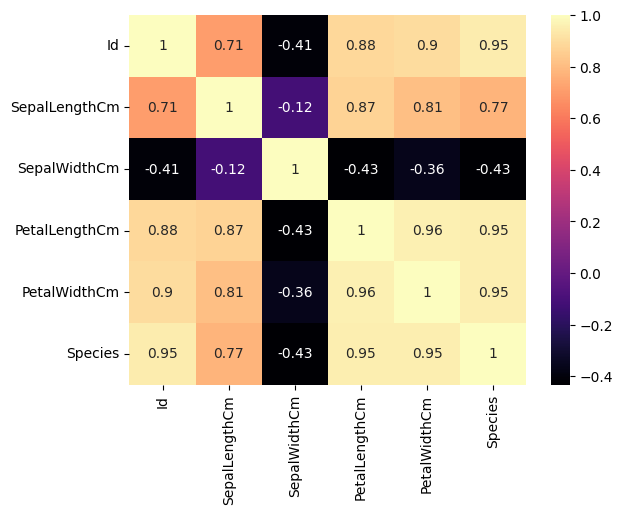

In [11]:
sns.heatmap(train_dataset.df.corr(), annot=True, cmap='magma')
plt.show()

In [12]:
class IrisNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.inLayer = nn.Linear(4, 16)
        self.hidLayer = nn.Linear(16, 16)
        self.outLayer = nn.Linear(16, 3)
        self.relu = nn.ReLU()


        self.linear_layers = nn.Sequential(
            self.inLayer,
            self.relu,
            
            self.hidLayer,
            self.relu,

            self.outLayer
        )
    
    def forward(self, x):
        return self.linear_layers(x)

In [13]:
model = IrisNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [15]:
num_epochs = 25
for epoch in range(num_epochs):
    correct = 0
    n_samples = 0

    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1)
        correct += (labels == pred).sum().item()
        n_samples += len(labels)

    print(f'Epoch {epoch} Accuracy: {correct / n_samples}')

Epoch 0 Accuracy: 0.7916666666666666
Epoch 1 Accuracy: 0.825
Epoch 2 Accuracy: 0.8166666666666667
Epoch 3 Accuracy: 0.8083333333333333
Epoch 4 Accuracy: 0.7833333333333333
Epoch 5 Accuracy: 0.775
Epoch 6 Accuracy: 0.7916666666666666
Epoch 7 Accuracy: 0.7833333333333333
Epoch 8 Accuracy: 0.7833333333333333
Epoch 9 Accuracy: 0.7833333333333333
Epoch 10 Accuracy: 0.7666666666666667
Epoch 11 Accuracy: 0.7833333333333333
Epoch 12 Accuracy: 0.8
Epoch 13 Accuracy: 0.8083333333333333
Epoch 14 Accuracy: 0.8083333333333333
Epoch 15 Accuracy: 0.8166666666666667
Epoch 16 Accuracy: 0.8083333333333333
Epoch 17 Accuracy: 0.8166666666666667
Epoch 18 Accuracy: 0.8333333333333334
Epoch 19 Accuracy: 0.8333333333333334
Epoch 20 Accuracy: 0.8416666666666667
Epoch 21 Accuracy: 0.85
Epoch 22 Accuracy: 0.8583333333333333
Epoch 23 Accuracy: 0.8583333333333333
Epoch 24 Accuracy: 0.8583333333333333


In [16]:
model.eval()
predictions = []
n_samples = 0

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        _, pred = torch.max(outputs, 1)
        predictions.extend(pred.cpu().numpy())
        n_samples += len(pred)

predictions = np.array(predictions)

In [17]:
submission_df = pd.DataFrame({'Id': test_dataset.df['Id'].values, 'Category': encoder.inverse_transform(predictions)})
submission_df.head(5)

,Id,Category
0,88,Iris-versicolor
1,112,Iris-virginica
2,11,Iris-setosa
3,92,Iris-virginica
4,50,Iris-setosa


In [18]:
submission_df.to_csv('./../submissions/iris-submission.csv', index=False)

### Score
This approach allowed us to score 0.95 in public ranking :D.